# Data 

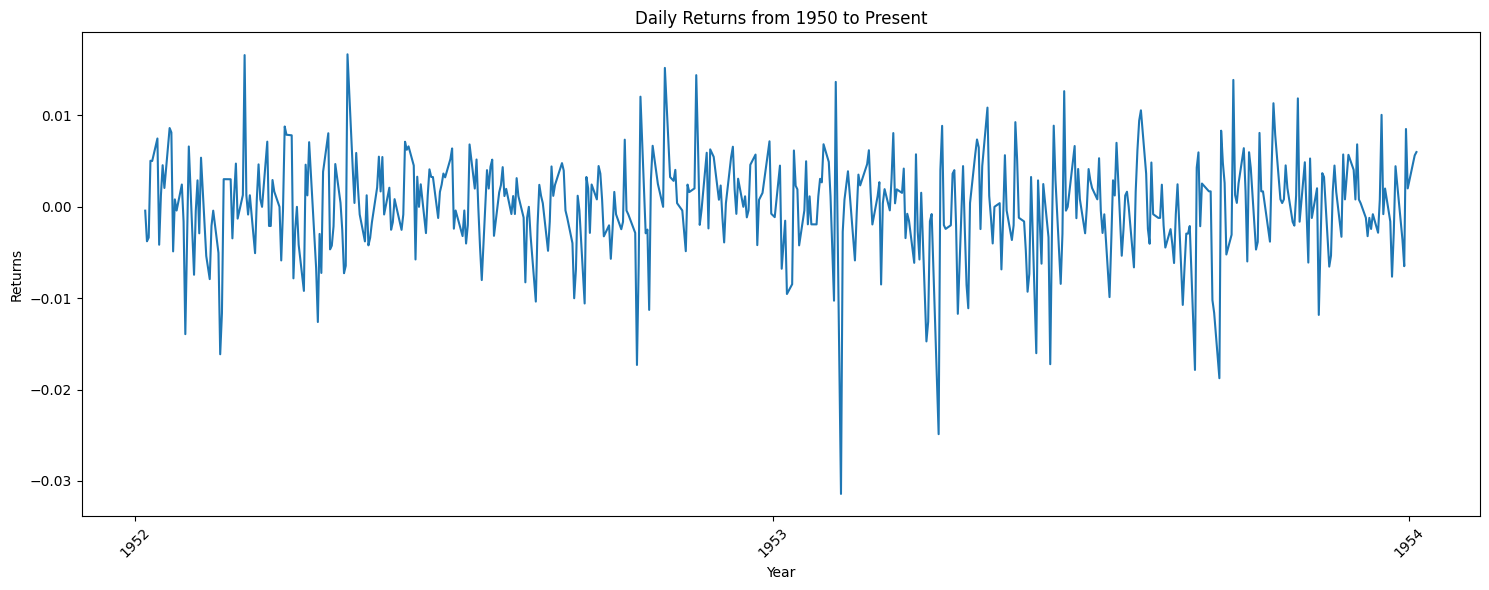

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
# insert code here
import matplotlib.dates as mdates
import seaborn as sns
from scipy.optimize import minimize

data = pd.read_csv('SP.csv', sep=';')

data['Date'] = pd.to_datetime(data['Date'])
data = data.iloc[500:1000]
plt.figure(figsize=(15, 6))
plt.plot(data['Date'], data['Return'])
plt.xlabel('Year')
plt.ylabel('Returns')
plt.title('Daily Returns from 1950 to Present')

# Setting x-axis to show only the years
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
y = data['Return']

# Functions

In [2]:
def create_parameters(n_states, sigma2):
    # Create the transition matrix
    transition_matrix = np.full((n_states, n_states), (1 - 0.95) / (n_states - 1))
    np.fill_diagonal(transition_matrix, 0.95)
    transition_matrix = transition_matrix[:-1]  # Remove the last row

    # Generate sigma values
    sigmas = [np.sqrt(sigma2 * (2 ** (-i))) for i in range(n_states)]

    # Combine transition matrix and sigmas into one array
    parameters = np.concatenate((transition_matrix.flatten(), sigmas))

    return np.array(parameters)

def emission_probability(y, mu, phi, sigma):
    s = sigma
    value = np.exp(-0.5 * np.log(np.pi) - 0.5 * np.log(s) - 0.5 * ((y - 0)**2) / s)
    return value
    
def prediction_step(P, filtered_probability, t):
    predicted_probability = P.dot(filtered_probability[:, t])
    return predicted_probability

def filtering_step(eta, predicted_probability, t, n_states):
    filtered_probs = np.zeros(n_states)
    # denominator = sum(eta[state] * predicted_probability[state] for state in range(n_states))

    # if denominator == 0:
    #     # Handle zero denominator if needed
    #     denominator = 0.0001
    # else:
    #     for state in range(n_states):
    #         filtered_probability[state] = eta[state] * predicted_probability[state] / sum(eta[state] * predicted_probability[state] for state in range(n_states))
    for state in range(n_states):
        filtered_probs[state] = eta[state] * predicted_probability[state] / sum(eta[state] * predicted_probability[state] for state in range(n_states))

    return filtered_probs
    # filtered_probability = np.zeros(n_states)
    # denominator = sum(eta[state] * predicted_probability[state] for state in range(n_states))
    # for state in range(n_states):
    #     filtered_probability[state] = eta[state] * predicted_probability[state] / denominator
    # return filtered_probability

def likelihood(params, y, n_states):
    # Calculate the length of the transition matrix parameters
    transition_params_length = n_states * (n_states - 1)
    # print(y)
    # Check if params array has the correct length
    expected_length = transition_params_length + n_states
    if len(params) != expected_length:
        raise ValueError(f"Expected params of length {expected_length}, got {len(params)}")

    # Extract transition matrix parameters and sigma values
    transition_params = params[:transition_params_length].reshape((n_states - 1, n_states))
    sigma2 = params[transition_params_length:]**2
    T = len(y)  # Number of observations

    # Create transition matrix P
    P = np.zeros((n_states, n_states))
    P[:-1, :] = transition_params
    for i in range(n_states):
        P[-1, i] = 1 - sum(transition_params[:, i])


    # Bookkeeping with renamed variables
    predicted_probability = np.zeros([n_states, T + 1])
    filtered_probability = np.zeros([n_states, T])
    smoothed_probability = np.zeros([n_states, T])
    likelihood_contributions = np.zeros(T)

    # Set the first row of predicted_probabilities as 1/n_states
    predicted_probability[:, 0] = 1 / n_states
    eta = np.zeros(n_states)
    for t in range(T):
        # Emission probabilities for each state
        eta = [emission_probability(y[t], sigma2[state]) for state in range(n_states)]

        # Likelihood
        likelihood_contributions[t] = np.log(sum(predicted_probability[state, t] * eta[state] for state in range(n_states)))

        # Filtering step
        filtered_probability[:, t] = filtering_step(eta, predicted_probability[:, t], t, n_states)
        
        # Prediction step
        predicted_probability[:, t + 1] = prediction_step(P, filtered_probability, t)

    total_likelihood =-np.sum(likelihood_contributions)
    print(total_likelihood)
    return total_likelihood  #We wish to minimize the likelihood in our scipy opt function


def print_parameters(parameters):
    print("Current Parameters:", parameters)

def parameter_bounds(n_states):
    # Transition probabilities bounds
    trans_bounds = [(0.001, 0.9999)] * n_states * (n_states - 1)

    # Sigma bounds
    sigma_bounds = [(0.01, 1000)] * n_states

    # Combine and return
    return trans_bounds + sigma_bounds

def hamilton_filter(y, n_states):
    # Initial variance estimate
    sigma2 = np.var(y)

    # Initial parameters
    parameters = create_parameters(n_states, sigma2)
    y = y.reset_index(drop=True)
    y = y.to_numpy()
    print(y)
    print("Now transformed:")
    
    y=y.T[0,:] 
    print(y)
    # Define bounds
    bounds = parameter_bounds(n_states)
    
    # Debugging: Print parameters and bounds to check their structure
    # print("Initial Parameters:", parameters)
    # print("Bounds:", bounds)
    # Define callback function
    callback_func = print_parameters
    # Optimization
    res = minimize(likelihood, parameters, args=(y, n_states), method='L-BFGS-B', bounds=bounds, callback=callback_func)

    # Extracting results
    optimized_params = res.x
    v_hessian = res.hess_inv.todense()
    se_hessian = np.sqrt(np.diagonal(v_hessian))

    return optimized_params, v_hessian, se_hessian


# Minimize

In [3]:
# # Example usage
# n_states = 3  # Example for more than 2 states
# sigma2 = np.var(y)
# params = create_parameters(n_states, sigma2)
# y = y.reset_index(drop=True)
# try:
#     likelihood_value = likelihood(params, y, n_states)
# except ValueError as e:
#     print(e)

In [3]:
# Assuming y is your data series and n_states is the number of states
n_states = 3  # Example

optimized_params, v_hessian, se_hessian = hamilton_filter(y,n_states)
print("Optimized Parameters:", optimized_params)
print("Variance-Covariance Matrix:", v_hessian)
print("Standard Errors:", se_hessian)



[-0.00041815 -0.00377122 -0.00336417  0.00504207  0.00501669  0.00747822
 -0.0041477   0.00124615  0.00455586  0.00206394  0.00862247  0.00814341
 -0.00487802  0.00081458 -0.00040725  0.00244109 -0.00162672 -0.01393465
 -0.00372136  0.00660613 -0.0074349  -0.00041468  0.00289911 -0.00289911
  0.00537743 -0.00537743 -0.0079118  -0.00209245 -0.00041902 -0.00504207
 -0.01613619 -0.01162558  0.00302703  0.00301789 -0.00344977  0.00129506
  0.00473429 -0.00128898  0.00128898  0.01660668  0.00126605 -0.0008438
  0.00126547 -0.00507182  0.00084714  0.00464622  0.00084246  0.
  0.0071324  -0.00209245 -0.00209692  0.00293436  0.00167298  0.
 -0.00586754 -0.00042043  0.00879214  0.00788877  0.00782706 -0.00782706
 -0.00248443  0.         -0.0041546  -0.00920128  0.00461124  0.00125396
  0.00707599 -0.00665837 -0.01260525 -0.00296422 -0.00723561  0.00383714
  0.00805264 -0.00465417 -0.0042499  -0.00213174  0.00468389  0.00042463
 -0.00255098 -0.00726344 -0.00645302  0.01669198  0.00423554  0.0004

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed